# Torus valued data, i.e. $\mathbb{T}_2$, on line- and grid-graph, i.e. $\mathbb{T}_2$-signal and images

### with generalization to any $d$-dimensional torus $\mathbb{T}_d = \times_{i=1}^d \mathbb{S}_1$
### arXiv: [Denoising of Sphere- and SO(3)-Valued Data by Relaxed Tikhonov Regularization](https://arxiv.org/abs/2307.10980)

In [551]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.interpolate import CubicSpline
from scipy.stats import vonmises
from scipy.stats import vonmises_fisher

import imp
import relaxed_tikhonov_sphere
import relaxed_tikhonov_sphere_image

In [552]:
imp.reload(relaxed_tikhonov_sphere)
imp.reload(relaxed_tikhonov_sphere_image)

<module 'relaxed_tikhonov_sphere_image' from '/Users/jonasbresch/Desktop/cycle valued data/python/finale/github/relaxed_tikhonov_sphere_image.py'>

In [535]:
Noise, Data = relaxed_tikhonov_sphere.sample_torus_vMF_signal(2, 20, 10)

normalization test :  1.0
normalization test :  1.0


In [544]:
Noise, Data = relaxed_tikhonov_sphere_image.sample_torus_vMF_image(2, 10, 10)

### Main algorithm

- ADMM_red_torus : solving the proposed simplified and generalized convex optimization problem in ...

In [531]:
def ADMM_red_torus_1D(y, y_0, lam, rho, iter):

    d, N = np.shape(y)
    r = int(d/2)
    M = N-1

    x = np.zeros((d, N))
    l = np.zeros((r, M))
    U = np.zeros((r,M,4,4))
    Z = np.zeros((r,M,4,4))

    for i in range(iter):

        for k in range(r):
            [adjx, adjl] = relaxed_tikhonov_sphere.adjL_red(U[k,:,:,:] - Z[k,:,:,:], N, 2)

            #s <- argmin_s f(s) + rho/2*||Ls - u + z||^2  ------- first ADMM-step
            x[2*k:2*k+2,0] = 1/2*(adjx[:,0] + 1/rho*y[2*k:2*k+2,0])
            x[2*k:2*k+2,1:N-1] = 1/4*(adjx[:,1:N-1] + 1/rho*y[2*k:2*k+2,1:N-1])
            x[2*k:2*k+2,N-1] = 1/2*(adjx[:,N-1] + 1/rho*y[2*k:2*k+2,N-1])
            l[k,:] = 1/2*(adjl + 1/rho*lam)

            #U <- argmin (.) = prox_{hpsd + I => 0}(.)  ------- second ADMM-step
            temp = relaxed_tikhonov_sphere.L_red(x[2*k:2*k+2,:], l[k,:], N, 2)
            #Utemp = U
            U[k, :,:,:] = relaxed_tikhonov_sphere.ADMMprox(temp.copy() + Z[k, :,:,:], N)

            #Z <- Z + Ls - U  ------- third ADMM-step // update
            Z[k, :,:,:] += temp - U[k,:,:,:]
        
        norm = np.zeros((r, N))
        for w in range(r):
            norm[w,:] = np.sum(x[2*w:2*w+2,:]**2, 0)
        
        if np.mod(i, 100) == 0:
            print('func-value = ', "%10.2e"% (np.sum(-np.sum(x*y, 0)) - lam*np.sum(l)), '\t| torus-error = ', "%10.2e"% np.linalg.norm(1 - norm))
    
    return [x, l]

In [383]:
def ADMM_red_torus_2D(y, y_0, lam, rho, iter):

    d, N, N = np.shape(y)
    r = int(d/2)
    M = N-1

    x = np.zeros((d, N, N))
    l1 = np.zeros((r, M, N))
    l2 = np.zeros((r, N, M))
    U1 = np.zeros((r,M,N,4,4))
    U2 = np.zeros((r,N,M,4,4))
    Z1 = np.zeros((r,M,N,4,4))
    Z2 = np.zeros((r,N,M,4,4))

    for i in range(iter):

        for k in range(r):
            [adjx, adjl1, adjl2] = relaxed_tikhonov_sphere_image.adjL_red(U1[k,:,:,:,:] - Z1[k,:,:,:,:], U2[k,:,:,:,:] - Z2[k,:,:,:,:], N, 2)

            #s <- argmin_s f(s) + rho/2*||Ls - u + z||^2  ------- first ADMM-step
            x[2*k:2*k+2,0,0] = 1/4*(adjx[:,0,0] + 1/rho*y[2*k:2*k+2,0,0])
            x[2*k:2*k+2,0,N-1] = 1/4*(adjx[:,0,N-1] + 1/rho*y[2*k:2*k+2,0,N-1])
            x[2*k:2*k+2,N-1,0] = 1/4*(adjx[:,N-1,0] + 1/rho*y[2*k:2*k+2,N-1,0])
            x[2*k:2*k+2,N-1,N-1] = 1/4*(adjx[:,N-1,N-1] + 1/rho*y[2*k:2*k+2,N-1,N-1])

            x[2*k:2*k+2,0,1:N-1] = 1/6*(adjx[:,0,1:N-1] + 1/rho*y[2*k:2*k+2,0,1:N-1])
            x[2*k:2*k+2,1:N-1,0] = 1/6*(adjx[:,1:N-1,0] + 1/rho*y[2*k:2*k+2,1:N-1,0])
            x[2*k:2*k+2,N-1,1:N-1] = 1/6*(adjx[:,N-1,1:N-1] + 1/rho*y[2*k:2*k+2,N-1,1:N-1])
            x[2*k:2*k+2,1:N-1,N-1] = 1/6*(adjx[:,1:N-1,N-1] + 1/rho*y[2*k:2*k+2,1:N-1,N-1])

            x[2*k:2*k+2,1:N-1,1:N-1] = 1/8*(adjx[:,1:N-1,1:N-1] + 1/rho*y[2*k:2*k+2,1:N-1,1:N-1])

            l1[k,:,:] = 1/2*(adjl1 + 1/rho*lam)
            l2[k,:,:] = 1/2*(adjl2 + 1/rho*lam)

            #U <- argmin (.) = prox_{hpsd + I => 0}(.)  ------- second ADMM-step
            temp1, temp2 = relaxed_tikhonov_sphere_image.L_red(x[2*k:2*k+2,:,:], l1[k,:,:], l2[k,:,:], N, 2)
            #Utemp = U
            [U1[k,:,:,:,:], U2[k,:,:,:,:]] = relaxed_tikhonov_sphere_image.proxADMM(temp1.copy() + Z1[k,:,:,:,:], temp2.copy() + Z2[k,:,:,:,:], N)

            #Z <- Z + Ls - U  ------- third ADMM-step // update
            Z1[k,:,:,:,:] += temp1 - U1[k,:,:,:,:]
            Z2[k,:,:,:,:] += temp2 - U2[k,:,:,:,:]
        
        norm = np.zeros((r, N, N))
        for w in range(r):
            norm[w,:,:] = np.sum(x[2*w:2*w+2,:,:]**2, 0)
        
        if np.mod(i, 100) == 0:
            print('func-value = ', "%10.2e"% (np.sum(-np.sum(x*y, 0)) - lam*np.sum(l1) - lam*np.sum(l2)), '\t| torus-error = ', "%10.2e"% np.linalg.norm(1 - np.sqrt(norm)))
    
    return [x, l1, l2]

In [536]:
sol_x, sol_l = relaxed_tikhonov_sphere.ADMM_red_torus_1D(Noise, Data, 10, 0.1, 1000)

iteration 	| func-value 	| torus-error
------------------------------------------------------------
0 		|  -4.01e+05 	|   1.56e+02


100 		|  -8.75e+03 	|   1.75e-02
200 		|  -8.75e+03 	|   2.96e-03
300 		|  -8.75e+03 	|   7.15e-04
400 		|  -8.75e+03 	|   2.17e-04
500 		|  -8.75e+03 	|   7.21e-05
600 		|  -8.75e+03 	|   2.48e-05
700 		|  -8.75e+03 	|   8.70e-06
800 		|  -8.75e+03 	|   3.09e-06
900 		|  -8.75e+03 	|   1.10e-06


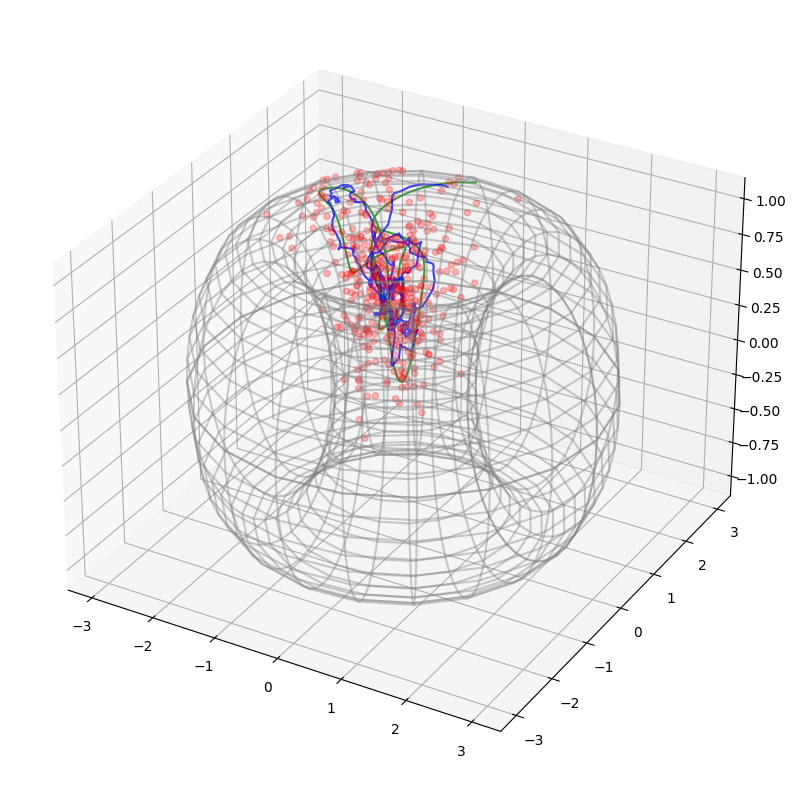

In [539]:
relaxed_tikhonov_sphere.plotTorus(Noise, Data, sol_x)

In [559]:
sol_x, sol_l1, sol_l2 = relaxed_tikhonov_sphere_image.ADMM_red_torus_2D(Noise, Data, 2, 0.1, 1000)

iteration 	| func-value 	| torus-error
---------------------------------------------------
0 		|  -6.61e+05 	|   -2.69e-01
100 		|  -7.87e+04 	|    6.68e-03
200 		|  -7.86e+04 	|    6.37e-03
300 		|  -7.86e+04 	|    6.18e-03
400 		|  -7.86e+04 	|    6.05e-03
500 		|  -7.86e+04 	|    5.97e-03
600 		|  -7.86e+04 	|    5.90e-03
700 		|  -7.86e+04 	|    5.86e-03
800 		|  -7.86e+04 	|    5.81e-03
900 		|  -7.86e+04 	|    5.77e-03


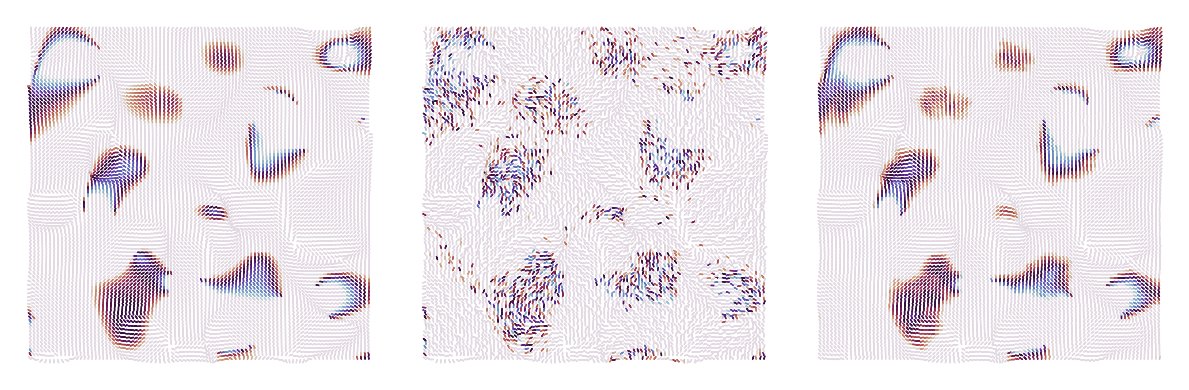

In [560]:
relaxed_tikhonov_sphere_image.plotTorus(Noise, Data, sol_x)